![](http://storage.googleapis.com/kaggle-competitions/kaggle/29653/logos/header.png?t=2021-07-07-17-26-56)
# Interactive Task1 EDA
In this notebook, you will find
* How useful are Task1 scans for Task2 (this competition).
* How to build interactive figures with Plotly.
* That Task2 is not about finding tumors.


In [1]:
import tarfile
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def extract_task1_files(root="./data"):
    tar = tarfile.open("../input/brats-2021-task1/BraTS2021_Training_Data.tar")
    tar.extractall(root)
    tar.close()

In [ ]:
extract_task1_files()

# 1. Introduction

RSNA-MICCAI Brain Tumor Radiogenomic Classification is a second part to the RSNA-ASNR-MICCAI BraTS 2021 challenge. First part focuses on multiclass segmentation, this one (Task 2) - on binary classification.

> The RSNA-ASNR-MICCAI BraTS 2021 challenge utilizes ... mpMRI scans, and focuses on (**Task 1**) the evaluation of state-of-the-art methods for the **segmentation** of intrinsically heterogeneous **brain glioblastoma sub-regions** in mpMRI scans.
>
> Furthermore, this year's challenge also focuses on (**Task 2**) the evaluation of **classification** methods to predict the **MGMT promoter methylation status** at pre-operative baseline scans.

Task 1 sub-regions are defined as

> ... the **GD-enhancing tumor** (ET — label **4**), the peritumoral edematous/**invaded tissue** (ED — label **2**), and the **necrotic tumor core** (NCR — label **1**).

Both tasks share matching patient ids. Can task1 scans be used in task2?

# 2. Plotting 3D MRI scans

First, let's take a peek at how task1 scans look in 3D. To plot them, we need to rasterize stacked images into a point cloud with reduced dimensionality. Passing each scanned pixel into our visualization would net us more than a million points, so we need to 1) resize every image to 128x128 and 2) downsample space without tumor for brevity.

In [2]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
        
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'{self.root}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_{scan_type}.nii.gz'
        return self.read_file(scan_filename)
            

A 3D point cloud is visualized by utilizing the Plotly library. Generating a trace (plotly.graph_objects.Scatter3d) per tissue type allows us to simultaneously show different point clouds with different opacities on a single 3D graph (plotly.graph_objects.Figure).
The resulting figure is interactive. Try to rotate it or disable overlaying tumor tissue types.

In [3]:
import plotly.graph_objects as go
import numpy as np


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader,
        mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale

    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 and 1/5 pixels for tumor tissue classes 1(core), 2(invaded) and 4(enhancing)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        return [
            generate_3d_scatter(
                **clean_mri, scale=self.mri_colorscale, opacity=0.4,
                hover='skip', name='Brain MRI'
            ),
            generate_3d_scatter(
                **tumors[1], opacity=0.8,
                hover='all', name='Necrotic tumor core'
            ),
            generate_3d_scatter(
                **tumors[2], opacity=0.4,
                hover='all', name='Peritumoral invaded tissue'
            ),
            generate_3d_scatter(
                **tumors[4], opacity=0.4,
                hover='all', name='GD-enhancing tumor'
            ),
        ], markers_created
    
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0, r=0, b=0, t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig

In [4]:
reader = ImageReader('./data', img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=20)

Positive scan: a tumor is present.

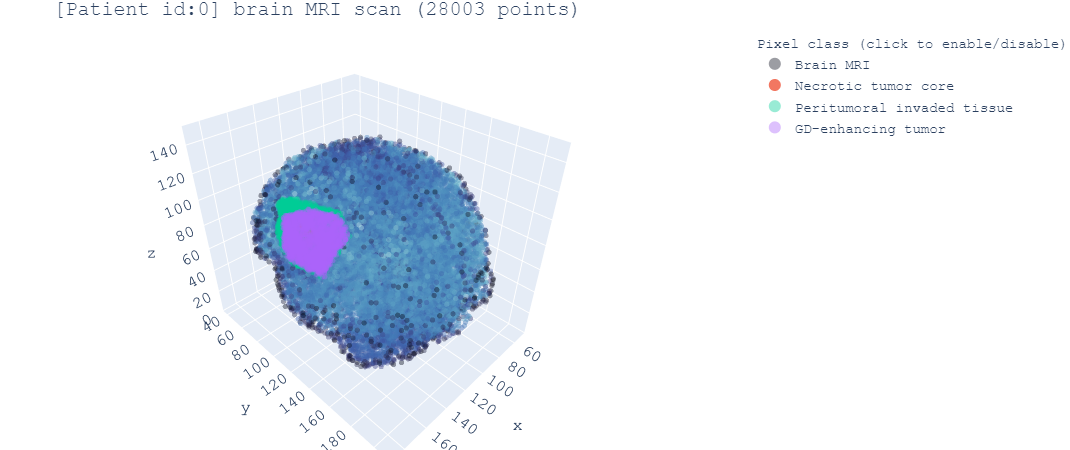

In [5]:
fig = viewer.get_3d_scan(0, 't1')
plotly.offline.iplot(fig)

Negative scan: a tumor is present too.

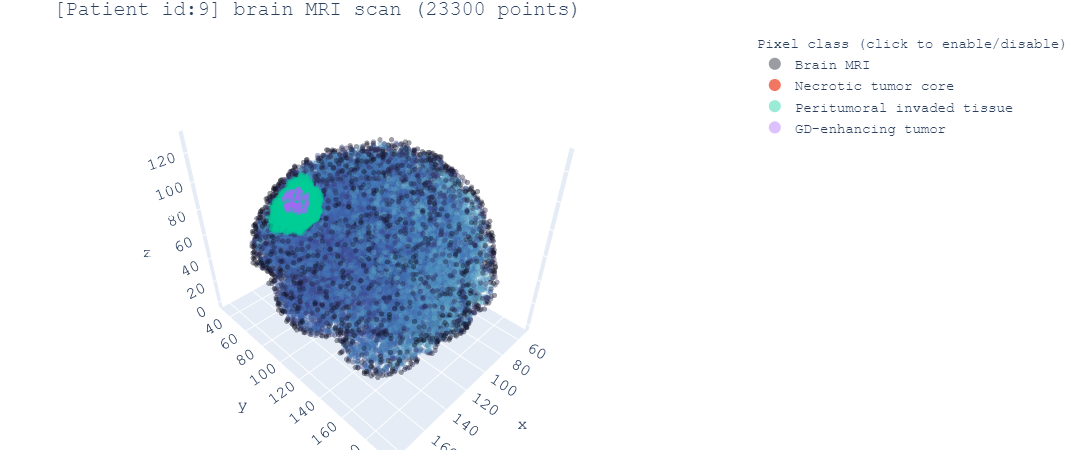

In [6]:
fig = viewer.get_3d_scan(9, 'flair')
plotly.offline.iplot(fig)

As you can see, we're not looking at whether a tumor is present on an MRI scan, but rather *classifying a type of this tumor* (with or without MGMT promoter methylation).

# 3. Feature engineering

Let's collect a simple set of features - centroids for tumor cores and overall tumor size relative to a full MRI scan.

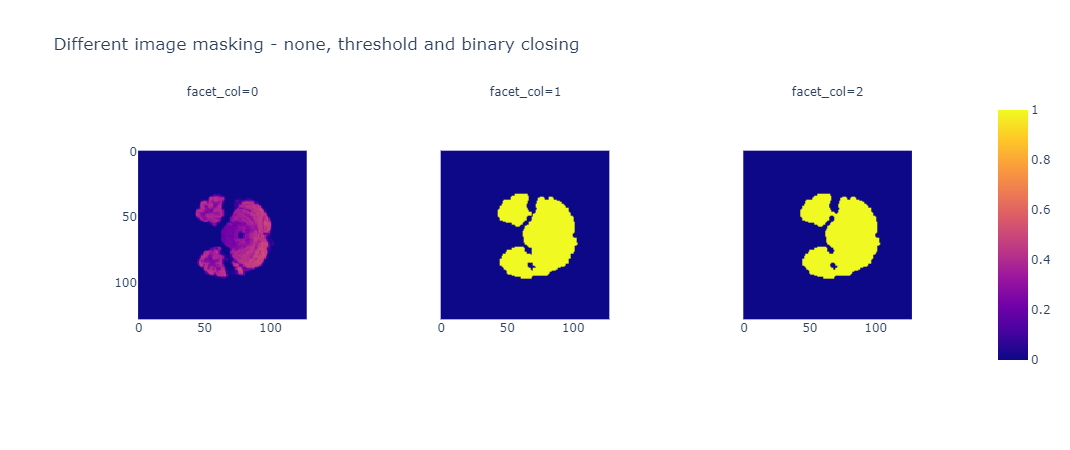

In [7]:
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][40]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

Tumor to all tissue ratio can be (approximately) calculated as (sum of tumor pixels/sum of tissue pixels)

In [8]:
def get_approx_pixel_count(scan:np.array, close:bool=False, mask:bool=False, mask_idx:int=-1) -> int:
    slice_areas = []
    for slice_idx in range(scan.shape[0]):
        if close:
            mri = 1 * binary_closing(scan[slice_idx, :, :])
        elif mask_idx >= 0:
            mri = 1 * (scan[slice_idx, :, :] == mask_idx)
        elif mask:
            mri = 1 * (scan[slice_idx, :, :] > 0)
        else:
            raise ValueError('Masking mechanism should be specified')
        mri_area = mri.sum()
        slice_areas.append(mri_area)
    return np.sum(slice_areas)

get_approx_pixel_count(data['segmentation'], mask=True) / get_approx_pixel_count(data['scan'], mask=True)

0.0378232673703338

In [9]:
def get_centroid(scan:np.array, mask_idx:int=1) -> list:
    z, x, y = (scan == mask_idx).nonzero()
    x, y, z = np.median(x), np.median(y), np.median(z)
    return [x/scan.shape[1], y/scan.shape[2], z/scan.shape[0]]

get_centroid(data['segmentation'], 4), get_centroid(data['segmentation'], 1)

([0.578125, 0.3671875, 0.44516129032258067],
 [0.5859375, 0.359375, 0.45161290322580644])

Putting everything into one DataFrame.

In [10]:
import pandas as pd
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
targets = dict(zip(df.BraTS21ID, df.MGMT_value))

In [11]:
%%time

features = []
for patient_idx in targets:
    try:
        data = reader.load_patient_scan(patient_idx)
        scan_px = get_approx_pixel_count(data['scan'], mask=True)
        tumor_px = get_approx_pixel_count(data['segmentation'], mask=True)
        core_px = get_approx_pixel_count(data['segmentation'], mask_idx=4)
        dimension = np.product(data['scan'].shape)
        patient_features = [patient_idx, targets[patient_idx]]
        patient_features.extend([scan_px/dimension, tumor_px/dimension, tumor_px/scan_px, core_px/tumor_px])
        patient_features.extend(get_centroid(data['segmentation'], 4))
        features.append(patient_features)
    except FileNotFoundError:
        continue

CPU times: user 5min 3s, sys: 1min 28s, total: 6min 31s
Wall time: 3min 19s


In [12]:
df = pd.DataFrame(
    features, columns=['idx', 'target', 'scan_pct', 'tumor_pct', 'tumor_ratio', 'core_ratio', 'x', 'y', 'z']
).set_index('idx')

df

target  scan_pct  tumor_pct  tumor_ratio  core_ratio         x  \
idx                                                                    
0          1  0.169896   0.006426     0.037823    0.569520  0.578125   
2          1  0.160032   0.021350     0.133414    0.125157  0.593750   
3          0  0.185514   0.011115     0.059917    0.241179  0.523438   
5          1  0.148663   0.013974     0.093995    0.191456  0.625000   
6          1  0.174226   0.015398     0.088381    0.190927  0.531250   
...      ...       ...        ...          ...         ...       ...   
1005       1  0.156157   0.012003     0.076863    0.324464  0.429688   
1007       1  0.178173   0.006243     0.035041    0.472722  0.625000   
1008       1  0.160777   0.004695     0.029204    0.166303  0.375000   
1009       0  0.161348   0.006054     0.037523    0.225106  0.437500   
1010       0  0.172383   0.005835     0.033846    0.306810  0.640625   

             y         z  
idx                       
0     0.367188  0.445161  
2     0.390625  0.516129  
3     0.476562  0.664516  
5     0.640625  0.729032  
6     0.281250  0.438710  
...        ...       ...  
1005  0.617188  0.509677  
1007  0.601562  0.316129  
1008  0.500000  0.503226  
1009  0.437500  0.580645  
1010  0.625000  0.341935  

[577 rows x 8 columns]

Is there a difference between 1 and 0 classes? Let's look at the tumor volume percent:

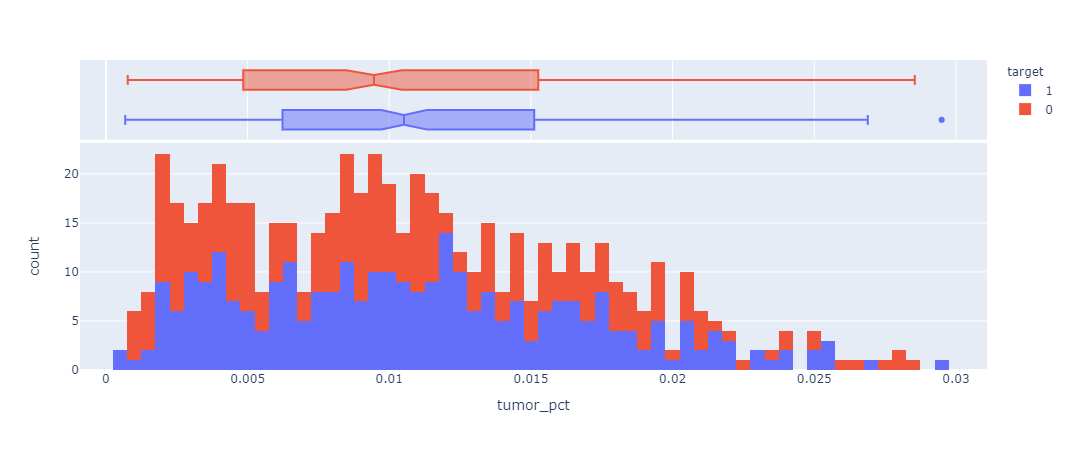

In [13]:
fig = px.histogram(
    df, x="tumor_pct", color="target", marginal="box",
    nbins=100, barmode='relative'
)
fig.show()

Or tumor to matter ratio:

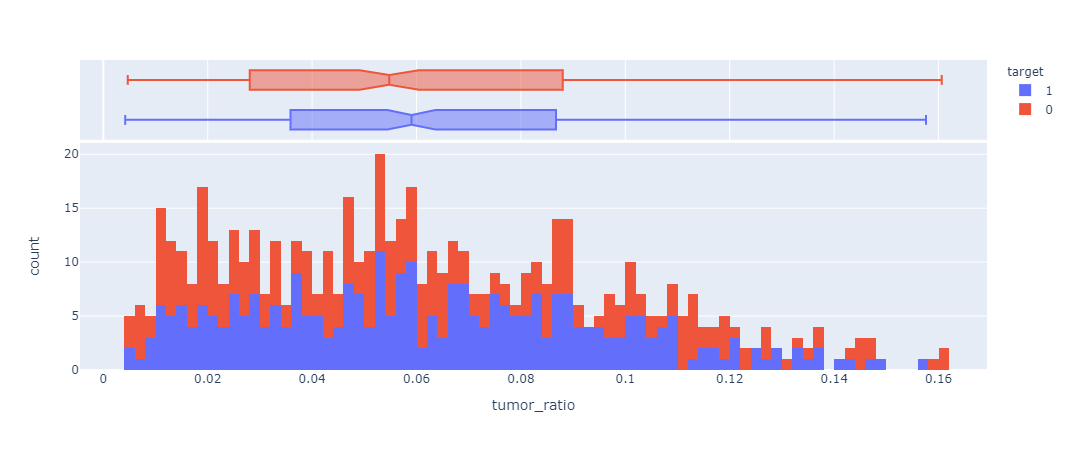

In [14]:
fig = px.histogram(
    df, x="tumor_ratio", color="target", marginal="box",
    nbins=100, barmode='relative'
)
fig.show()

There appears to be a slight difference. Is it significant enough to help in task one?

# 4. Models

If there is indeed such a difference then a simple model would pick it up. Let's build an ensemble of KNN, decision tree and logistic regression classifiers.

In [15]:
from sklearn.model_selection import train_test_split

X, y = df.drop('target', axis=1).values, df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
print(f'train: {X_train.shape[0]} scans, test: {X_test.shape[0]} scans')

train: 490 scans, test: 87 scans


In [16]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, log_loss

models = [
    RidgeClassifier(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=60),
]

def train_ensemble(models:list, data:tuple, print_individual:bool=False):
    X_train, X_test, y_train, y_test = data
    full_preds = []
    for clf in models:
        clf.fit(X_train, y_train)
        try:
            preds = clf.predict_proba(X_test)[:, 1]
        except AttributeError:
            preds = clf.predict(X_test)
        full_preds.append(preds)
        if print_individual:
            print(
                clf.__class__.__name__.ljust(25), '  scores:',
                roc_auc_score(y_test, preds), 'ROC AUC; ',
                log_loss(y_test, preds), 'loss.'
            )
    return full_preds

ensemble_predictions = train_ensemble(models, (X_train, X_test, y_train, y_test), True)
print('average:'.rjust(35), roc_auc_score(y_test, np.mean(ensemble_predictions, 0)), 'ROC AUC')

RidgeClassifier             scores: 0.511904761904762 ROC AUC;  17.07116520579385 loss.
DecisionTreeClassifier      scores: 0.553968253968254 ROC AUC;  15.483111151062197 loss.
KNeighborsClassifier        scores: 0.5746031746031747 ROC AUC;  0.6994147133159765 loss.
                           average: 0.5738095238095238 ROC AUC


**0.56 - 0.65** ROC AUC score with simple features - not great, not terrible (and not very representative of our data).

In [17]:
split_scores = []
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    models = [RidgeClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=60)]
    ensemble_predictions = train_ensemble(models, (X_train, X_test, y_train, y_test), False)
    split_scores.append(roc_auc_score(y_test, np.mean(ensemble_predictions, 0)))
print('mean', np.mean(split_scores), 'max', np.max(split_scores))

mean 0.575821115628104 max 0.6354087089381207


**0.56 - 0.6** ROC AUC average for different random seeds with 0.75-0.25 train-test split.

In [18]:
split_scores = []
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    y_test = np.random.permutation(y_test)
    models = [RidgeClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=60)]
    ensemble_predictions = train_ensemble(models, (X_train, X_test, y_train, y_test), False)
    split_scores.append(roc_auc_score(y_test, np.mean(ensemble_predictions, 0)))
print('mean', np.mean(split_scores), 'max', np.max(split_scores))

mean 0.5032343994550981 max 0.6052380952380952


Worse results for randomly shuffled test labels. Nonetheless, a random model can still score up to 0.7 ROC AUC with a (un)lucky seed.

# 5. Conclusion
It is possible to achieve a ~0.64 local validation ROC AUC Task2 score just with the simple features derived from Task1 data. In theory, using Task1 scans in Task2 should improve model quality. However, pure Task2 image encoders could be learning to find the same features on their own.

Unfortunately, not all patient ids from Task2 are present in Task1, so one-to-one conversion is not straightforward. Nevertheless, a pretrained segmentation model can be used instead.